In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from tqdm import tqdm # for nice progress bars
import math
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.datasets import load_iris
import urllib.request

In [2]:
multimodal_train = pd.read_csv('../regression/multimodal-sparse-training.csv')
multimodal_test = pd.read_csv('../regression/multimodal-sparse-test.csv')

# MLP

In [3]:
def relu(x, derivative=False):
    if derivative:
        return (x > 0).astype(float)
    return np.maximum(0, x)

def sigmoidal(x, derivative=False):
    sig = 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    if derivative:
        return sig * (1 - sig)
    return sig

def linear(x, derivative=False):
    if derivative:
        return np.ones_like(x)
    return x

def tanh(x, derivative=False):
    if derivative:
        return 1 - np.tanh(x)**2
    return np.tanh(x)

def softmax(x, derivative=False):
    if derivative:
        return np.ones_like(x)
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

In [4]:
class MLPBackprop:
    def __init__(self, layers, 
                 hidden_activation_function='sigmoid', 
                 output_activation_function='sigmoid', 
                 starting_weights=None, 
                 starting_biases=None,
                 momentum=0.0,            
                 rmsprop_decay=0.0,   
                 rmsprop_epsilon=1e-8,
                 l1_regularization=0.0,
                 l2_regularization=0.0):    
        
        self.layers = layers
        self.weights = []
        self.biases = []
        self.print_epoch = True
        self.weight_history = []
        self.bias_history = []
        activation_functions = {"relu": relu, "sigmoid": sigmoidal, "linear": linear, "softmax": softmax, "tanh": tanh}
        
        self.l1_regularization = l1_regularization
        self.l2_regularization = l2_regularization
        
        if hidden_activation_function in activation_functions:
            self.hidden_activation_function = activation_functions[hidden_activation_function]
        else:
            raise ValueError("Invalid hidden activation function, choose from:", activation_functions)
        
        if output_activation_function in activation_functions:
            self.output_activation_function = activation_functions[output_activation_function]
        else:
            raise ValueError("Invalid output activation function, choose from:", activation_functions)
        
        self.momentum = momentum
        self.rmsprop_decay = rmsprop_decay
        self.rmsprop_epsilon = rmsprop_epsilon
        
        for i in range(len(self.layers) - 1):
            n_input = self.layers[i]
            n_output = self.layers[i + 1]
            
            activation_function = self.hidden_activation_function if i < len(self.layers) - 2 else self.output_activation_function
            
            if activation_function == sigmoidal:
                weight_matrix = np.random.normal(0, np.sqrt(2 / (n_input + n_output)), size=(n_input, n_output))
            elif activation_function == relu:
                weight_matrix = np.random.uniform(- np.sqrt(2 / n_input), np.sqrt(2 / n_input), size=(n_input, n_output))
            else:
                weight_matrix = np.random.randn(n_input, n_output)
            self.weights.append(weight_matrix)
            self.biases.append(np.zeros((1, n_output)))
        
        if self.momentum > 0:
            self.weight_velocities = [np.zeros_like(w) for w in self.weights]
            self.bias_velocities = [np.zeros_like(b) for b in self.biases]
        
        if self.rmsprop_decay > 0:
            self.weight_cache = [np.zeros_like(w) for w in self.weights]
            self.bias_cache = [np.zeros_like(b) for b in self.biases]
    
    def forward(self, X):
        if isinstance(X, np.ndarray) and X.ndim == 1:
            X = X.reshape(-1, 1)
        
        self.z_values = []
        self.activations = [X]
        activation = X
        
        for i in range(len(self.weights) - 1):
            z = np.dot(activation, self.weights[i]) + self.biases[i]
            self.z_values.append(z)
            activation = self.hidden_activation_function(z)
            self.activations.append(activation)
            
        z = np.dot(activation, self.weights[-1]) + self.biases[-1]
        self.z_values.append(z)
        output = self.output_activation_function(z)
        self.activations.append(output)
        return output
    
    def predict(self, X):
        if isinstance(X, np.ndarray) and X.ndim == 1:
            X = X.reshape(-1, 1)
        return self.forward(X)
    
    def backpropagation(self, X, y, learning_rate=0.01):
        if isinstance(X, np.ndarray) and X.ndim == 1:
            X = X.reshape(1, -1)
        if isinstance(y, np.ndarray) and y.ndim == 1:
            y = y.reshape(1, -1)
        
        N = X.shape[0]
        output = self.forward(X)
        
        d_loss = (output - y) / N
        
        if self.output_activation_function in [sigmoidal, relu, tanh]:
            delta = d_loss * self.output_activation_function(self.z_values[-1], derivative=True)
        elif self.output_activation_function == softmax:
            delta = d_loss
        else:
            delta = d_loss
            
        deltas = [delta]
        
        for i in range(len(self.weights) - 1, 0, -1):
            delta = np.dot(deltas[0], self.weights[i].T) * self.hidden_activation_function(self.z_values[i-1], derivative=True)
            deltas.insert(0, delta)
        
        for i in range(len(self.weights)):
            grad_w = np.dot(self.activations[i].T, deltas[i])
            grad_b = np.sum(deltas[i], axis=0, keepdims=True)
            
            if self.l1_regularization > 0:
                l1_grad = self.l1_regularization * np.sign(self.weights[i])
                grad_w += l1_grad
            
            if self.l2_regularization > 0:
                l2_grad = self.l2_regularization * self.weights[i]
                grad_w += l2_grad
            
            if self.rmsprop_decay > 0:
                self.weight_cache[i] = self.rmsprop_decay * self.weight_cache[i] + (1 - self.rmsprop_decay) * (grad_w ** 2)
                self.bias_cache[i] = self.rmsprop_decay * self.bias_cache[i] + (1 - self.rmsprop_decay) * (grad_b ** 2)
                adjusted_grad_w = grad_w / (np.sqrt(self.weight_cache[i]) + self.rmsprop_epsilon)
                adjusted_grad_b = grad_b / (np.sqrt(self.bias_cache[i]) + self.rmsprop_epsilon)
            else:
                adjusted_grad_w = grad_w
                adjusted_grad_b = grad_b
            
            if self.momentum > 0:
                self.weight_velocities[i] = self.momentum * self.weight_velocities[i] + learning_rate * adjusted_grad_w
                self.bias_velocities[i] = self.momentum * self.bias_velocities[i] + learning_rate * adjusted_grad_b
                self.weights[i] -= self.weight_velocities[i]
                self.biases[i] -= self.bias_velocities[i]
            else:
                self.weights[i] -= learning_rate * adjusted_grad_w
                self.biases[i] -= learning_rate * adjusted_grad_b

    def compute_regularization_loss(self):
        reg_loss = 0
        
        if self.l1_regularization > 0:
            l1_term = sum(np.sum(np.abs(w)) for w in self.weights)
            reg_loss += self.l1_regularization * l1_term
        
        if self.l2_regularization > 0:
            l2_term = sum(np.sum(w**2) for w in self.weights)
            reg_loss += 0.5 * self.l2_regularization * l2_term
            
        return reg_loss
        
    def compute_loss(self, X, y, include_regularization=True):
        predictions = self.predict(X)
        mse_loss = np.mean(np.square(y - predictions))
        
        if include_regularization:
            reg_loss = self.compute_regularization_loss()
            return mse_loss + reg_loss
        else:
            return mse_loss

    def train(self, X, y, epochs=1000, learning_rate=0.02, batch_size=0, 
              validation_data=None, patience=10, min_delta=0.0001, verbose=1):
        if isinstance(X, np.ndarray) and X.ndim == 1:
            X = X.reshape(1, -1)
        if isinstance(y, np.ndarray) and y.ndim == 1:
            y = y.reshape(1, -1)
        
        best_loss = np.inf
        self.loss_history = []
        self.val_loss_history = []
        best_weights = None
        best_biases = None
        self.weight_history = []
        self.bias_history = []
        no_improvement_count = 0

        if verbose == 1:
            progress_bar = tqdm(range(epochs), desc="Training")
        else:
            progress_bar = range(epochs)

        for epoch in progress_bar:
            if batch_size == 0:
                self.backpropagation(X, y, learning_rate)
            else:
                indices = np.random.permutation(X.shape[0])
                X_shuffled = X[indices]
                y_shuffled = y[indices]
                
                for i in range(0, X.shape[0], batch_size):
                    X_batch = X_shuffled[i:i + batch_size]
                    y_batch = y_shuffled[i:i + batch_size]
                    self.backpropagation(X_batch, y_batch, learning_rate)
            
            train_loss = self.compute_loss(X, y, include_regularization=True)
            self.loss_history.append(train_loss)
            
            current_weights = [w.copy() for w in self.weights]
            current_biases = [b.copy() for b in self.biases]
            self.weight_history.append(current_weights)
            self.bias_history.append(current_biases)
            
            if validation_data is not None:
                X_val, y_val = validation_data
                
                if isinstance(X_val, np.ndarray) and X_val.ndim == 1:
                    X_val = X_val.reshape(1, -1)
                if isinstance(y_val, np.ndarray) and y_val.ndim == 1:
                    y_val = y_val.reshape(1, -1)
                
                val_loss = self.compute_loss(X_val, y_val, include_regularization=False)
                self.val_loss_history.append(val_loss)
                
                if verbose == 1:
                    progress_bar.set_postfix(train_loss=f"{train_loss:.6f}", val_loss=f"{val_loss:.6f}")
                elif verbose == 2:
                    print(f"Epoch {epoch+1}/{epochs} - train_loss: {train_loss:.6f} - val_loss: {val_loss:.6f}")
                
                if val_loss < best_loss - min_delta:
                    best_loss = val_loss
                    best_weights = [w.copy() for w in self.weights]
                    best_biases = [b.copy() for b in self.biases]
                    no_improvement_count = 0
                else:
                    no_improvement_count += 1
                    
                if no_improvement_count >= patience:
                    if verbose > 0:
                        print(f"\nEarly stopping at epoch {epoch+1}. Best validation loss: {best_loss:.6f}")
                    break
            else:
                if train_loss < best_loss:
                    best_loss = train_loss
                    best_weights = [w.copy() for w in self.weights]
                    best_biases = [b.copy() for b in self.biases]
                
                if verbose == 1:
                    progress_bar.set_postfix(train_loss=f"{train_loss:.6f}")
                elif verbose == 2:
                    print(f"Epoch {epoch+1}/{epochs} - train_loss: {train_loss:.6f}")
        
        if best_weights is not None:
            self.weights = best_weights
            self.biases = best_biases
            if verbose > 0:
                print(f'Best loss: {best_loss:.6f}')

    def set_weights_and_biases(self, layer_idx, w, b):
        self.weights[layer_idx] = w
        self.biases[layer_idx] = b
    
    def mse(self, y_true, y_pred):
        return np.mean((y_true - y_pred) ** 2)

    def plot_history(self, figsize=(15, 10), save_path=None, max_neurons_per_plot=10):
        if not self.weight_history:
            raise ValueError("No weight history available. Train the network first.")
        
        num_layers = len(self.weights)
        num_epochs = len(self.weight_history)
        epochs = np.arange(num_epochs)
        
        total_subplots = num_layers * 2 + 1
        
        cols = min(2, total_subplots)
        rows = math.ceil(total_subplots / cols)
        
        fig, axes = plt.subplots(rows, cols, figsize=figsize)
        
        if total_subplots > 1:
            axes = axes.flatten()
        else:
            axes = [axes]
        
        subplot_idx = 0
        
        ax_loss = axes[subplot_idx]
        subplot_idx += 1
        
        ax_loss.plot(epochs, self.loss_history, '-', linewidth=2, label='Training Loss')
        if hasattr(self, 'val_loss_history') and self.val_loss_history:
            ax_loss.plot(epochs, self.val_loss_history, '-', linewidth=2, label='Validation Loss')
        
        ax_loss.set_title('Loss History')
        ax_loss.set_xlabel('Epoch')
        ax_loss.set_ylabel('Loss (MSE)')
        ax_loss.grid(True, alpha=0.3)
        ax_loss.legend()
        
        for layer_idx in range(num_layers):
            input_size, output_size = self.weights[layer_idx].shape
            ax_weights = axes[subplot_idx]
            subplot_idx += 1
            
            total_weights = input_size * output_size
            if total_weights > max_neurons_per_plot:
                indices_flat = np.random.choice(total_weights, max_neurons_per_plot, replace=False)
                indices = [(idx // output_size, idx % output_size) for idx in indices_flat]
            else:
                indices = [(i, j) for i in range(input_size) for j in range(output_size)]
            
            for i, j in indices:
                weight_values = [self.weight_history[epoch][layer_idx][i, j] for epoch in range(num_epochs)]
                ax_weights.plot(epochs, weight_values, '-', linewidth=1, 
                            label=f'w_{i+1},{j+1}' if total_weights <= 20 else None)
            
            ax_weights.set_title(f'Layer {layer_idx+1}: Weights')
            ax_weights.set_xlabel('Epoch')
            ax_weights.set_ylabel('Weight Value')
            ax_weights.grid(True, alpha=0.3)
            if total_weights <= 20:
                ax_weights.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            
            ax_biases = axes[subplot_idx]
            subplot_idx += 1
            
            bias_size = self.biases[layer_idx].shape[1]
            if bias_size > max_neurons_per_plot:
                bias_indices = np.random.choice(bias_size, max_neurons_per_plot, replace=False)
            else:
                bias_indices = range(bias_size)
            
            for j in bias_indices:
                bias_values = [self.bias_history[epoch][layer_idx][0, j] for epoch in range(num_epochs)]
                ax_biases.plot(epochs, bias_values, '-', linewidth=1, 
                            label=f'b_{j+1}' if bias_size <= 20 else None)
            
            ax_biases.set_title(f'Layer {layer_idx+1}: Biases')
            ax_biases.set_xlabel('Epoch')
            ax_biases.set_ylabel('Bias Value')
            ax_biases.grid(True, alpha=0.3)
            if bias_size <= 20:
                ax_biases.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        for i in range(subplot_idx, len(axes)):
            axes[i].axis('off')
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        
        plt.show()

Wzięty z NN6 :)

# AE

In [5]:
class GeneticAlgorithmMLP:
    def __init__(self, mlp_structure, population_size=50, mutation_rate=0.1, 
                 crossover_rate=0.8, elitism_rate=0.1, tournament_size=3):
        self.mlp_structure = mlp_structure
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.elitism_rate = elitism_rate
        self.tournament_size = tournament_size
        
        self.total_params = 0
        self.weight_shapes = []
        self.bias_shapes = []
        
        for i in range(len(mlp_structure.weights)):
            w_shape = mlp_structure.weights[i].shape
            b_shape = mlp_structure.biases[i].shape
            self.weight_shapes.append(w_shape)
            self.bias_shapes.append(b_shape)
            self.total_params += np.prod(w_shape) + np.prod(b_shape)
        
        self.population = None
        self.fitness_history = []
        self.best_fitness_history = []
        
    def create_individual(self):
        return np.random.randn(self.total_params) * 0.5
    
    def create_population(self):
        return np.array([self.create_individual() for _ in range(self.population_size)])
    
    def decode_individual(self, individual):
        weights = []
        biases = []
        idx = 0
        
        for i in range(len(self.weight_shapes)):
            w_size = np.prod(self.weight_shapes[i])
            w = individual[idx:idx + w_size].reshape(self.weight_shapes[i])
            weights.append(w)
            idx += w_size
            
            b_size = np.prod(self.bias_shapes[i])
            b = individual[idx:idx + b_size].reshape(self.bias_shapes[i])
            biases.append(b)
            idx += b_size
            
        return weights, biases
    
    def evaluate_individual(self, individual, X, y, task_type='regression'):
        try:
            weights, biases = self.decode_individual(individual)
            for i in range(len(weights)):
                self.mlp_structure.weights[i] = weights[i]
                self.mlp_structure.biases[i] = biases[i]
            
            predictions = self.mlp_structure.predict(X)
            
            if task_type == 'classification':
                if predictions.shape[1] > 1:  # Multi-class
                    pred_classes = np.argmax(predictions, axis=1)
                    true_classes = np.argmax(y, axis=1) if y.shape[1] > 1 else y.flatten()
                else:  # Binary
                    pred_classes = (predictions > 0.5).flatten()
                    true_classes = y.flatten()
                
                accuracy = np.mean(pred_classes == true_classes)
                return accuracy 
            else:
                # For regression, use negative MSE as fitness (to be maximized)
                mse = np.mean((predictions - y) ** 2)
                return -mse
                
        except Exception as e:
            return -1e6 if task_type == 'regression' else 0
    
    def tournament_selection(self, population, fitness_scores):
        selected = []
        for _ in range(len(population)):
            tournament_indices = np.random.choice(len(population), self.tournament_size, replace=False)
            tournament_fitness = fitness_scores[tournament_indices]
            winner_idx = tournament_indices[np.argmax(tournament_fitness)]
            selected.append(population[winner_idx].copy())
        return np.array(selected)
    
    def crossover(self, parent1, parent2):
        if np.random.random() > self.crossover_rate:
            return parent1.copy(), parent2.copy()
        
        crossover_point = np.random.randint(1, len(parent1))
        child1 = np.concatenate([parent1[:crossover_point], parent2[crossover_point:]])
        child2 = np.concatenate([parent2[:crossover_point], parent1[crossover_point:]])
        return child1, child2
    
    def mutate(self, individual):
        mutated = individual.copy()
        mutation_mask = np.random.random(len(individual)) < self.mutation_rate
        mutated[mutation_mask] += np.random.normal(0, 0.1, np.sum(mutation_mask))
        return mutated
    
    def evolve_generation(self, population, fitness_scores):
        sorted_indices = np.argsort(-fitness_scores)
        sorted_population = population[sorted_indices]
        sorted_fitness = fitness_scores[sorted_indices]
        
        n_elite = int(self.elitism_rate * self.population_size)
        new_population = [sorted_population[i].copy() for i in range(n_elite)]
        
        while len(new_population) < self.population_size:
            selected = self.tournament_selection(population, fitness_scores)
            
            for i in range(0, len(selected) - 1, 2):
                if len(new_population) >= self.population_size:
                    break
                
                child1, child2 = self.crossover(selected[i], selected[i + 1])
                
                child1 = self.mutate(child1)
                child2 = self.mutate(child2)
                
                new_population.append(child1)
                if len(new_population) < self.population_size:
                    new_population.append(child2)
        
        return np.array(new_population[:self.population_size])
    
    def train(self, X, y, generations=100, task_type='regression', verbose=True):
        self.population = self.create_population()
        self.fitness_history = []
        self.best_fitness_history = []
        
        if verbose:
            progress_bar = tqdm(range(generations), desc="Evolving")
        else:
            progress_bar = range(generations)
        
        for generation in progress_bar:
            fitness_scores = np.array([
                self.evaluate_individual(ind, X, y, task_type) 
                for ind in self.population
            ])
            
            avg_fitness = np.mean(fitness_scores)
            best_fitness = np.max(fitness_scores)
            self.fitness_history.append(avg_fitness)
            self.best_fitness_history.append(best_fitness)
            
            if verbose:
                progress_bar.set_postfix(
                    avg_fitness=f"{avg_fitness:.6f}", 
                    best_fitness=f"{best_fitness:.6f}"
                )
            
            if generation < generations - 1:
                self.population = self.evolve_generation(self.population, fitness_scores)
        
        best_idx = np.argmax(fitness_scores)
        best_individual = self.population[best_idx]
        best_weights, best_biases = self.decode_individual(best_individual)
        
        for i in range(len(best_weights)):
            self.mlp_structure.weights[i] = best_weights[i]
            self.mlp_structure.biases[i] = best_biases[i]
        
        return best_fitness
    
    def plot_evolution(self):
        plt.figure(figsize=(12, 4))
        
        plt.subplot(1, 2, 1)
        plt.plot(self.fitness_history, label='Average Fitness')
        plt.plot(self.best_fitness_history, label='Best Fitness')
        plt.xlabel('Generation')
        plt.ylabel('Fitness')
        plt.title('Evolution History')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(1, 2, 2)
        plt.plot(self.best_fitness_history, 'r-', linewidth=2)
        plt.xlabel('Generation')
        plt.ylabel('Best Fitness')
        plt.title('Best Fitness Over Time')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

In [6]:
def load_iris_data():
    """Load and preprocess Iris dataset"""
    iris = load_iris()
    X = iris.data
    y = iris.target
    y_onehot = np.eye(3)[y]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return train_test_split(X_scaled, y_onehot, test_size=0.3, random_state=42)

def load_auto_mpg_data():
    url = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"
    
    try:
        urllib.request.urlretrieve(url, "auto-mpg.data")
        columns = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
                  'acceleration', 'model_year', 'origin', 'car_name']
        data = pd.read_csv("auto-mpg.data", sep='\s+', names=columns, na_values='?')
        data = data.dropna().drop('car_name', axis=1)
        X = data.drop('mpg', axis=1).values
        y = data['mpg'].values.reshape(-1, 1)
        scaler_X = StandardScaler()
        scaler_y = StandardScaler()
        X_scaled = scaler_X.fit_transform(X)
        y_scaled = scaler_y.fit_transform(y)
        return train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42), scaler_y
        
    except Exception as e:
        print(f"Error loading Auto MPG data: {e}")
        return None, None

<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
C:\Users\admin\AppData\Local\Temp\ipykernel_33820\3687234770.py:18: SyntaxWarning: invalid escape sequence '\s'
  data = pd.read_csv("auto-mpg.data", sep='\s+', names=columns, na_values='?')


# Tests

## iris

Evolving: 100%|██████████| 500/500 [00:17<00:00, 27.93it/s, avg_fitness=0.954603, best_fitness=0.990476]


Best training accuracy: 0.9905
Test accuracy: 1.0000


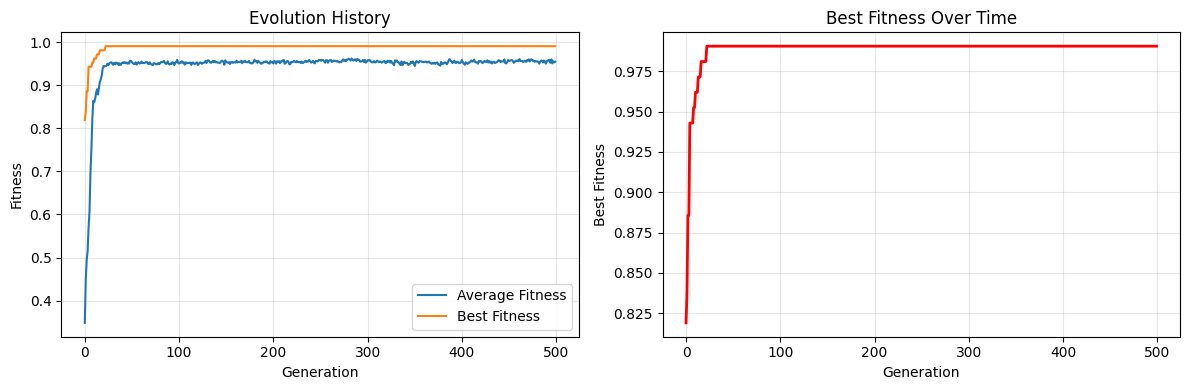

In [7]:
X_train, X_test, y_train, y_test = load_iris_data()
mlp = MLPBackprop([4, 8, 3], hidden_activation_function='relu', 
                    output_activation_function='softmax')
ga_trainer = GeneticAlgorithmMLP(mlp, population_size=300, mutation_rate=0.1)
best_fitness = ga_trainer.train(X_train, y_train, generations=500, 
                                task_type='classification')
predictions = mlp.predict(X_test)
pred_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)
accuracy = np.mean(pred_classes == true_classes)

print(f"Best training accuracy: {best_fitness:.4f}")
print(f"Test accuracy: {accuracy:.4f}")

ga_trainer.plot_evolution()

## multimodal

Evolving: 100%|██████████| 1000/1000 [00:13<00:00, 75.26it/s, avg_fitness=-0.193819, best_fitness=-0.073235]


Best training fitness: -0.073235
Test MSE: 872.105428


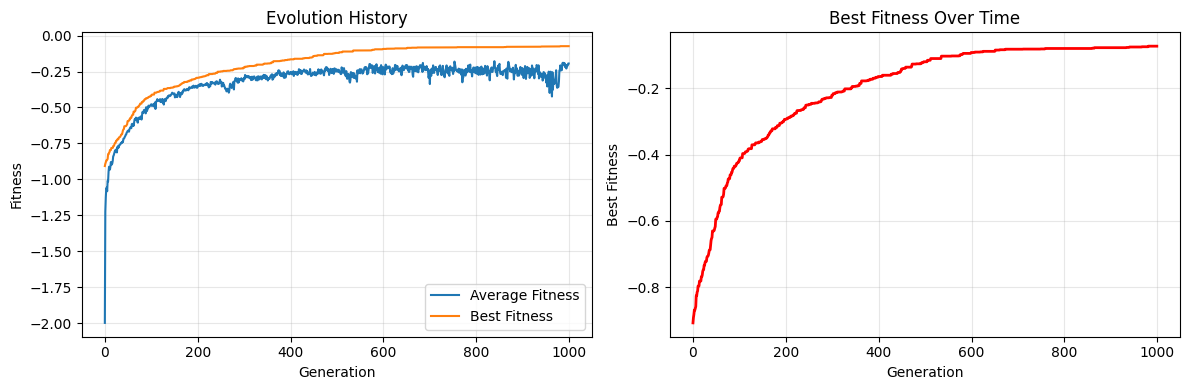

In [8]:
X_train = multimodal_train.iloc[:, 0].values.reshape(-1, 1)
y_train = multimodal_train.iloc[:, 1].values.reshape(-1, 1)
X_test = multimodal_test.iloc[:, 0].values.reshape(-1, 1)
y_test = multimodal_test.iloc[:, 1].values.reshape(-1, 1)


scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train)
mlp = MLPBackprop([1, 10, 10, 1], hidden_activation_function='sigmoid', 
                    output_activation_function='linear')
ga_trainer = GeneticAlgorithmMLP(mlp, population_size=100, mutation_rate=0.5)
best_fitness = ga_trainer.train(X_train_scaled, y_train_scaled, generations=1000, 
                                task_type='regression')

X_test_scaled = scaler_X.transform(X_test)
predictions = mlp.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(predictions)
mse = np.mean((y_pred - y_test) ** 2)

print(f"Best training fitness: {best_fitness:.6f}")
print(f"Test MSE: {mse:.6f}")

ga_trainer.plot_evolution()

## auto-mpg

Evolving: 100%|██████████| 100/100 [00:00<00:00, 146.86it/s, avg_fitness=-0.147156, best_fitness=-0.113512]


Best training fitness: -0.113512
Test MSE (scaled): 0.127313
Test MSE (original scale): 7.735861


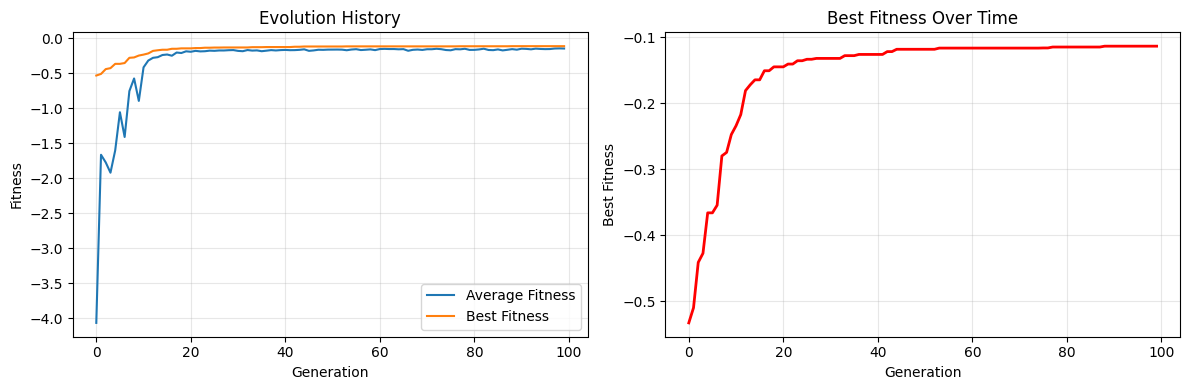

In [9]:
data_result, scaler_y = load_auto_mpg_data()
if data_result is not None:
    X_train, X_test, y_train, y_test = data_result
    mlp = MLPBackprop([X_train.shape[1], 12, 8, 1], 
                        hidden_activation_function='relu', 
                        output_activation_function='linear')
    
    ga_trainer = GeneticAlgorithmMLP(mlp, population_size=50, mutation_rate=0.12)
    best_fitness = ga_trainer.train(X_train, y_train, generations=100, 
                                    task_type='regression')
    predictions = mlp.predict(X_test)
    mse = np.mean((predictions - y_test) ** 2)
    pred_original = scaler_y.inverse_transform(predictions)
    test_original = scaler_y.inverse_transform(y_test)
    mse_original = np.mean((pred_original - test_original) ** 2)
    
    print(f"Best training fitness: {best_fitness:.6f}")
    print(f"Test MSE (scaled): {mse:.6f}")
    print(f"Test MSE (original scale): {mse_original:.6f}")
    
    ga_trainer.plot_evolution()
    